<a href="https://colab.research.google.com/github/BBotond03/SkinCancerDetection/blob/main/main_transfer_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script for Downloading the Data
1. We download the data  through the Kaggle API (for this we will have to provide out personal API key, this can be found at Kaggle profile settings).
2. Extract the downloaded zip file

In [13]:
#to be able to download the dataset to our current runtime
!pip install kaggle

In [14]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Get the actual file name from the dictionary
file_name = list(uploaded.keys())[0]
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Save the API key securely without displaying it
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded[file_name])

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


IndexError: list index out of range

In [ ]:
!kaggle competitions download -c isic-2024-challenge

In [ ]:
import zipfile
import os

# Path to your zip file and extract location
zip_file_path = 'isic-2024-challenge.zip'
extract_to_path = 'data'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
    print("Extraction completed.")

# Data Preproccessing

In [ ]:
!pip install tensorflow

In [ ]:
#neccesary imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_datasets as tfds
import shutil
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Load CSV
csv_path = './data/train-metadata.csv'
df = pd.read_csv(csv_path, low_memory=False)

# Append '.jpg' to each isic_id to match image filenames
df['isic_id'] = df['isic_id'].astype(str) + '.jpg'

# Directory where images are stored
img_dir = './data/train-image/image'  # Ensure this path is correct

# Filter for files that actually exist
df['filepath'] = df['isic_id'].apply(lambda x: os.path.join(img_dir, x))
df = df[df['filepath'].apply(os.path.exists)]

# Print out a summary
print(f"Number of valid images after filtering: {len(df)}")
print(df[['isic_id', 'filepath']].head())  # Optional: to verify paths

# Convert `target` to string for binary classification
df['target'] = df['target'].astype(str)

# Define ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create generator
train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=img_dir,
    x_col='isic_id',       # filename column
    y_col='target',         # target column
    target_size=(150, 150), # adjust as needed
    class_mode='binary',    # for binary classification
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=img_dir,
    x_col='isic_id',
    y_col='target',
    target_size=(150, 150),
    class_mode='binary',
    subset='validation'
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.utils import class_weight
import numpy as np


In [12]:
# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 10

# Initialize the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Calculate class weights
labels = df['target'].astype(int).values  # Ensure target values are integers (0 or 1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class Weights: {class_weights_dict}")

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath='best_melanoma_inceptionv3.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# Instead of using repeat(), calculate steps_per_epoch based on dataset size
train_steps_per_epoch = int(len(df) * (1 - 0.2) // BATCH_SIZE)  # Training data size / batch size
val_steps_per_epoch = int(len(df) * 0.2 // BATCH_SIZE)  # Validation data size / batch size


# Train the model with class weights and callbacks
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=train_steps_per_epoch,  # Use calculated steps_per_epoch
    validation_steps=val_steps_per_epoch,  # Use calculated validation_steps
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    class_weight=class_weights_dict
)

# Unfreeze some layers for fine-tuning
base_model.trainable = True
fine_tune_at = 249

# Freeze the layers before `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS // 2,
    steps_per_epoch=train_steps_per_epoch, #Fixed to use the correct variable
    validation_steps=val_steps_per_epoch, #Fixed to use the correct variable
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    class_weight=class_weights_dict
)

# Load the best saved model
best_model = tf.keras.models.load_model('best_melanoma_inceptionv3.keras')

# Evaluate the best model on the validation set
loss, accuracy = best_model.evaluate(val_gen)
print(f"Best Model Validation Accuracy: {accuracy:.2f}")

tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 74, 74, 32)     │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 74, 74, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 72, 72, 32)     │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 72, 72, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 72, 72, 64)     │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 35, 35, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 35, 35, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 35, 35, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 22,984,097 (87.68 MB)

 Trainable params: 1,181,313 (4.51 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Class Weights: {0: 0.5004904334283418, 1: 510.25318066157763}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10026/10026 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8965 - loss: 4.7452
Epoch 1: val_loss improved from inf to 0.47027, saving model to best_melanoma_inceptionv3.keras
10026/10026 ━━━━━━━━━━━━━━━━━━━━ 592s 57ms/step - accuracy: 0.8965 - loss: 4.7451 - val_accuracy: 0.9425 - val_loss: 0.4703 - learning_rate: 1.0000e-04
Epoch 2/10
    1/10026 ━━━━━━━━━━━━━━━━━━━━ 7:27 45ms/step - accuracy: 0.7188 - loss: 0.3207

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.47027 to 0.44526, saving model to best_melanoma_inceptionv3.keras
10026/10026 ━━━━━━━━━━━━━━━━━━━━ 6s 635us/step - accuracy: 0.7188 - loss: 0.3207 - val_accuracy: 0.9474 - val_loss: 0.4453 - learning_rate: 1.0000e-04
Epoch 3/10
10025/10026 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7574 - loss: 2.2702
Epoch 3: val_loss improved from 0.44526 to 0.18140, saving model to best_melanoma_inceptionv3.keras
10026/10026 ━━━━━━━━━━━━━━━━━━━━ 542s 54ms/step - accuracy: 0.7574 - loss: 2.2703 - val_accuracy: 0.9984 - val_loss: 0.1814 - learning_rate: 1.0000e-04
Epoch 4/10
    1/10026 ━━━━━━━━━━━━━━━━━━━━ 8:17 50ms/step - accuracy: 0.6875 - loss: 0.7648
Epoch 4: val_loss improved from 0.18140 to 0.15579, saving model to best_melanoma_inceptionv3.keras
10026/10026 ━━━━━━━━━━━━━━━━━━━━ 2s 158us/step - accuracy: 0.6875 - loss: 0.7648 - val_accuracy: 1.0000 - val_loss: 0.1558 - learning_rate: 1.0000e-04
Epoch 5/10
10026/10026 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - ac

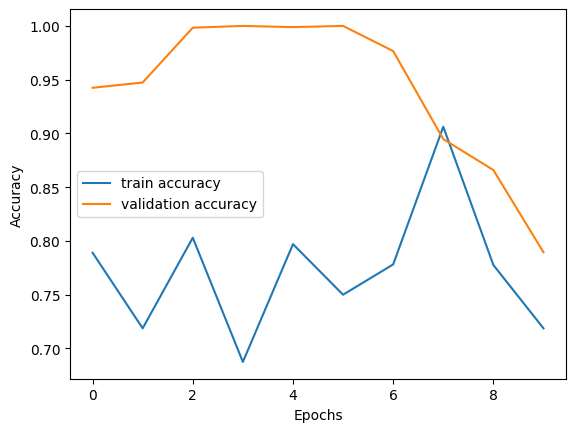

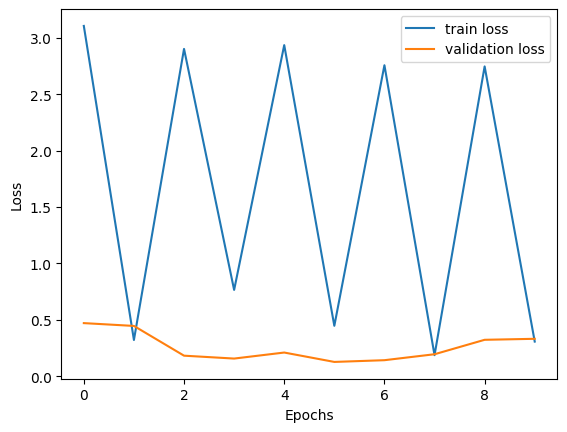

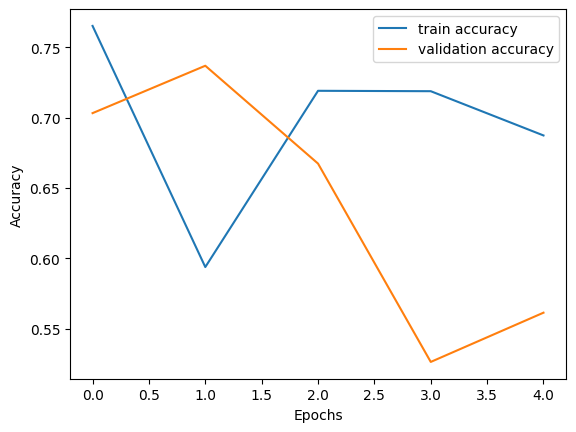

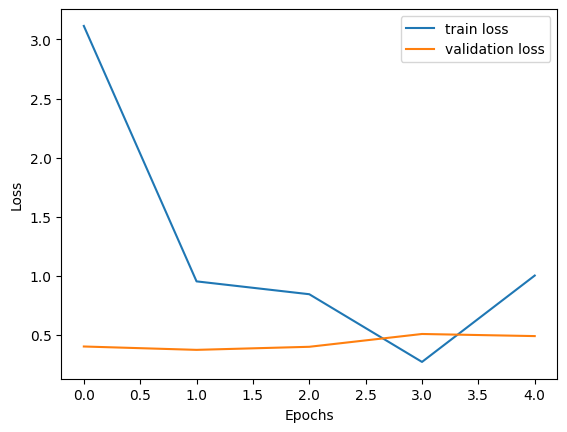

In [15]:
import matplotlib.pyplot as plt

def plot_training(history):
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training(history)
plot_training(history_fine)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Assuming `val_gen` is your validation generator and `model` is your trained model
# Make predictions on the validation data
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Threshold at 0.5 for binary classification

# Get the true labels from the validation generator
y_true = np.concatenate([y for x, y in val_gen], axis=0).flatten()  # Flatten for compatibility

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1']).plot(cmap='Blues', ax=ax, colorbar=False)

# Add title and metrics to the plot
plt.title('Confusion Matrix with Metrics')
plt.xlabel(f'Predicted Labels\n\nPrecision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}')
plt.ylabel('True Labels')
plt.show()



2507/2507 ━━━━━━━━━━━━━━━━━━━━ 112s 41ms/step


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Get the predicted probabilities
y_pred_prob = model.predict(val_gen).flatten()  # Flatten to a 1D array

# Get the true labels from the validation generator
y_true = np.concatenate([y for x, y in val_gen], axis=0).flatten()  # Flatten for compatibility

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [ ]:
# Visualize the network with keras visualizer
!pip3 install keras-visualizer
from keras_visualizer import visualizer
import matplotlib.image as mpimg
visualizer(model, file_format='png', view=True)
img = mpimg.imread('graph.png')
fig = plt.figure(figsize=[20,9])
plt.imshow(img)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs